# ESS: Analysing and interpreting FDEM data - PC class 2
---
# 0 - Introduction
To evaluate to which extent the collected FDEM data can help predict the spatial variability of your group's target properties, it is important to understand the relationship between the sensor output, and the targeted properties. In this notebook, you will be able to explore the underlying pedophysical relationships between the bulk electrical conductivity of a soil sample, and specific soil properties.

In a final segment of the notebook, you can develop stochastic models that can help predict the target property you have to explore.

In the first code cells, you once again import the required modules, as well as some basic functions that were deployed in the previous notebooks that you can use here as well.
In **_code cell 0.2_** the different available datasets are imported. Here you can also import your own datasets (such as inversion results etc.).

In [1]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [2]:
# Set the repository path:
# If the code is run in Google Colab This code will check if the repository is already cloned, if not it will clone it
# If the code is run locally, the repository path is set to the local path
# -------------------------------------------- #

if 'google.colab' in sys.modules:

    repo_path = '/content/I002658A_ESS'
    if not os.path.exists(repo_path):
        !git clone --branch funcbr https://github.com/SENSE-UGent/I002658A_ESS.git
    if repo_path not in sys.path:
        sys.path.append(repo_path)

else:

    repo_path = r'c:/Users/pdweerdt/Documents/Repos/I002658A_ESS' # Change this to the location of the repository on your machine
    if repo_path not in sys.path:
        sys.path.append(repo_path) 

# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file

requirements_path = repo_path + '/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

In [3]:
# Import the utility functions
from Utils.func import (
                        interpolate, export_grid, lin_sens, 
                        update_plot, update_plot2, 
                        waxsmits, linde, fu
                        )

In [4]:
'''
0.0 Import the required modules to run all code in this notebook.
    There is redundancy in the imports, but this is to ensure that all code
    can be run without having to worry about missing modules. Even if you 
    combine the notebook with cells from the first practicum.
'''
# General utility modules
import warnings
import re
import requests

# Modules for geopunt data visualisation
from IPython.display import HTML
from IPython.core.display import display
from ipywidgets import widgets, HBox, interact, FloatSlider

# Data visualisation, manipulation, and analysis
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.path
from matplotlib.backends.backend_pdf import PdfPages
from scipy.spatial import cKDTree
import scipy.stats
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import root

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter

from shapely.geometry import Point

# EMI 1D inversion package (emagpy)
from emagpy import Problem

%matplotlib inline

C:\Users\pdweerdt\AppData\Local\Temp\ipykernel_28024\1564817203.py:14: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


## Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository and store it on your Google Colab drive

In [5]:
# change the working directory to the cloned repository

# os.chdir('I002658A_ESS')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  c:\Users\pdweerdt\Documents\Repos\I002658A_ESS\Notebooks


### For local use

Only run the following cell if you have the data locally stored.

In [6]:
# set the working directory, place an r in front to address special characters
os.chdir(r'c:/Users/pdweerdt/Documents/Repos')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  c:\Users\pdweerdt\Documents\Repos


In [7]:
'''
0.1 Import datasets
*******************

Here you can import the datasets that you will use in the notebook. The datasets
consist of field data collected during the ESS2024 field campaign, which are 
provided via the URLs below. 
You can also import datasets that you have generated in previous notebooks. 
For those you can indicate the location on google drive (with Google Colab), or
on your local machine (with Jupyter Notebook/your own IDE).

'''
# Location of datasets generated in PC class 1 (02_ESS-... .ipynb)
FDEM_inverted_all = [] #dataset location Google Drive or local machine (string)
FDEM_inverted_samples = [] #dataset location Google Drive or local machine (string)

# Location of field datasets
EC_logs = cd + '//I002658A_ESS//Data//Survey2025//EC_logs_2024.csv'
samples = cd + '//I002658A_ESS//Data//Survey2025//samples_2024.csv' 

# **************************************************************************** #

# Provided dataset locations
FDEM_surveydata = cd + '//I002658A_ESS//Data//Survey2025//FDEM_2024.csv'
FDEM_transect = cd + '//I002658A_ESS//Data//Survey2025//FDEM_transect_2024.csv'


if FDEM_inverted_samples == []:
    FDEM_inverted_samples = cd + '//I002658A_ESS//Data//Example//FDEM_inv_samples_example.csv'
    warnings.warn('No dataset provided for FDEM_inverted_samples. Using example dataset instead.')
if FDEM_inverted_all == []:
    FDEM_inverted_all = cd + '//I002658A_ESS//Data//Example//FDEM_inverted_all_example.csv'
    warnings.warn('No dataset provided for FDEM_inverted_all. Using example dataset instead.')

# URL for grid masking file
blank_json = cd + '//I002658A_ESS//Data//Survey2025//blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0)
ds = pd.read_csv(samples, sep=',', header=0)
d_inv = pd.read_csv(FDEM_inverted_all, sep=',', header=0)
d_inv_samps = pd.read_csv(FDEM_inverted_samples, sep=',', header=0)
d_ec_logs = pd.read_csv(EC_logs, sep=',', header=0)
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')

C:\Users\pdweerdt\AppData\Local\Temp\ipykernel_28024\103558260.py:30: UserWarning: No dataset provided for FDEM_inverted_samples. Using example dataset instead.
  warnings.warn('No dataset provided for FDEM_inverted_samples. Using example dataset instead.')
C:\Users\pdweerdt\AppData\Local\Temp\ipykernel_28024\103558260.py:33: UserWarning: No dataset provided for FDEM_inverted_all. Using example dataset instead.
  warnings.warn('No dataset provided for FDEM_inverted_all. Using example dataset instead.')


### Set Export directory

Resulting dataframes, figures can also be exported to a specific folder. These files can be opened later for further analysis. It is important to know where you store your results.

In [8]:
#  let's have a look again at our current working directory
cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  c:\Users\pdweerdt\Documents\Repos


#### For saving files locally

In [9]:
#  Define the path where to export results, make sure the folder exists (create it if necessary)
export_path = cd + '//I002658A_ESS//Results'

print("Results will be exported to: ", export_path)

Results will be exported to:  c:\Users\pdweerdt\Documents\Repos//I002658A_ESS//Results


#### For saving files on Google Drive

In Google Colab, the contents folder files are temporarily. When the runtime is termminated, all data is lost. However, if you mount your Google Drive first, you can read and write files directly from and onto your Google Drive folders. In this way, your data is stored on the cloud and you can access it anywhere with your Google account.

Mount Drive first to Google Colab

In [10]:
# Mount Google Drive

if 'google.colab' in sys.modules:

    from google.colab import drive # import the drive method for mounting Google Drive
    drive.mount('/content/drive')

else:
    
    print('Google Colab is not running, not mounting Google Drive')

Google Colab is not running, not mounting Google Drive


You will probably get a message to authorize mounting Drive on Colab.

Next up we can set the filte path in Google Drive, below is the general code for saving files on your Drive Parent folder, best is to save it into a subfolder for this course for example: <br> **'/content/drive/My Drive/EnvSoilSens/Results**

In [11]:
# Define the file path in Google Drive
if 'google.colab' in sys.modules:

    export_path = '/content/drive/My Drive'

    print("Results will be exported to: ", export_path)

else:
    
    print('Google Colab is not running, not mounting Google Drive')

Google Colab is not running, not mounting Google Drive


In [12]:
'''
0.2 Basic functions
'''

# 0.2a Functions for interpolating and exporting data
# ----------------------------------------------------

help(interpolate)
help(export_grid)

Help on function interpolate in module Utils.func:

interpolate(x, y, z, cell_size, method='nearest', smooth_s=0, blank=None)
    Interpolate scatter data to regular grid through selected interpolation 
    method (with scipy.interpolate for simple interpolation).
    
    The output of this function is a Numpy array that holds the interpolated 
    data (accessed via `datagrid['grid']` in the cell below), alongside 
    the grid's cell size (`datagrid['cell_size']`) and the grid extent 
    (`datagrid['extent']`). The cell size and extent are needed to allow 
    exporting the interpolated data efficiently to a GeoTIF that can be 
    opened in any GIS software such as QGIS. 
    
    Parameters
    ----------
    x : np.array
        Cartesian GPS x-coordinates.
    
    y : np.array
        Cartesian GPS y-coordinates.
    
    z : np.array
        Data points to interpolate.
    
    cell_size : float
        Grid cell size (m).
    
    method : str, optional
        Scipy interpo

# 1 - Comparing FDEM data to analytical information at sampling locations
In **_code cell 1.0_** you can plot data of a specific coil pair, along with its cumulative sensitivities. 
In addition, in the third plot you can compare sample data (such as clay content, bulk density, ...) to ECa data collected at those locations with the different coil pairs. This way, you can already visually inspect the correlation between the recorded ECa values and the sampled soil properties.

In **_code cell 1.1_** you can compare the outcomes of your inversion at the sampling locations to the data from the EC logs.

The columns containing soil sample data in the ds (and d_inv_samps) dataframe and their units are presented in Table 1. Columns are only shown for samples collected at 10 cm depth, as units and datatypes are similar for 50 cm depth data.
> 
>|Column name|unit|datatype|
>|-----------|--------|--------|
>| *pH_H2O_10cm* | [-]|  pH water |
>| *bd_10cm* | [g/cm^3]|bulk density |
>| *vwc_10cm* | [%]| volumetric water content | 
>| *por_10cm* | [-]| porosity |
>| *CEC_10cm* | [meq/100g]| cation exchange capacity |
>| *clay_10cm* | [%]| clay content |
>| *silt_10cm* | [%]| silt content |
>| *sand_10cm* | [%]| sand content |
>| *TOC_10cm* | [g/kg]| total organic carbon |
>| *vmc_hydra* | [%]|  HydraProbe volumetric water content |
>| *EC_bulk_hydra* |[mS/m]|  HydraProbe bulk soil electrical conductivity |
>| *EC_water_hydra* | [mS/m]| HydraProbe soil water electrical conductivity |
>
> *Table 1: overview of sample data types.*

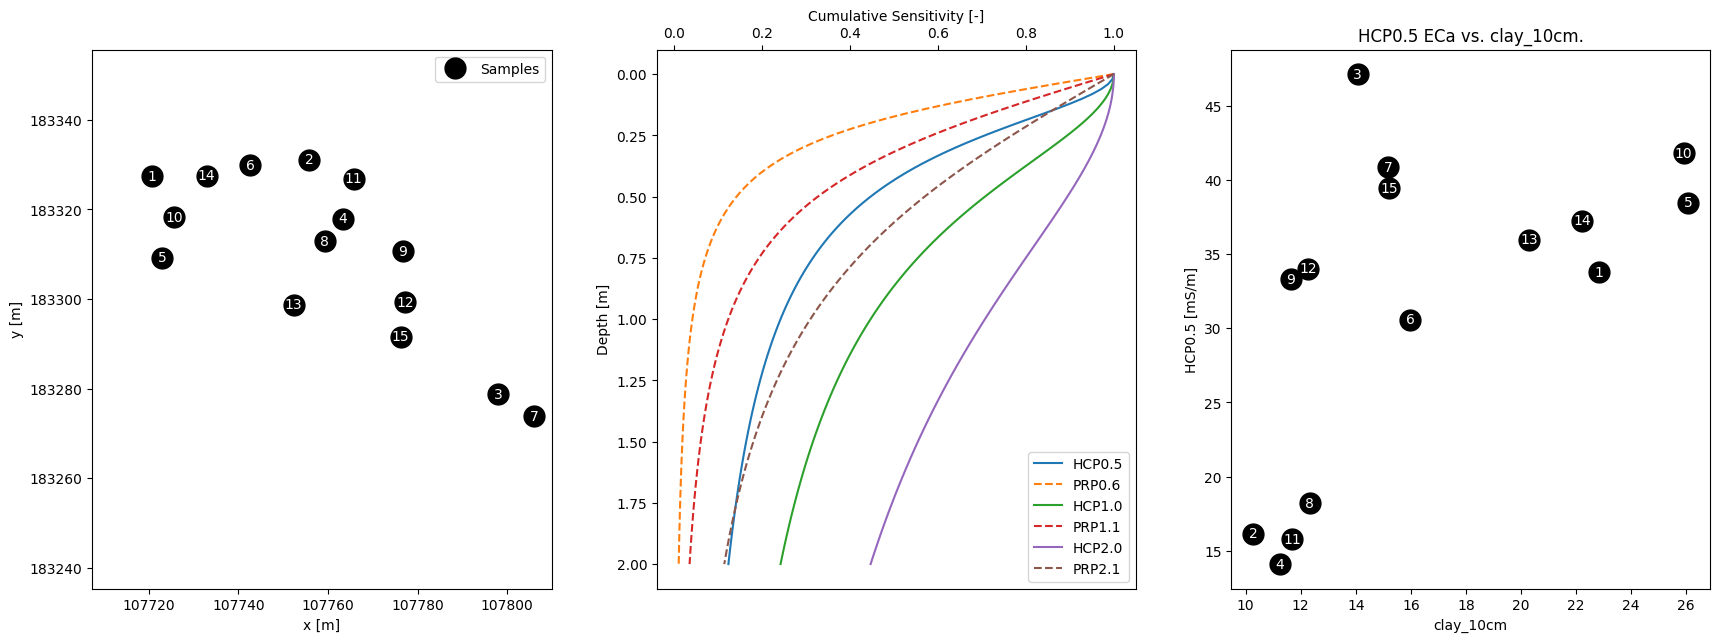

In [13]:
# 1.0: Evaluating FDEM data along the reference transect
# ------------------------------------------------------

"""
Plotting the relative sensitivity of the QP (LIN ECa) response of the 
deployed coil configurations. 
------------------------------------------------------------------------
For the third plot, you can evaluate the analytical data at the sampling 
locations (sample_col), and compare these to a selected FDEM dataset (fdem_col)
You can select the desired variables in the two lines of code below this 
comment. You can change these strings to visually evaluate the relationships
# between the analysed properties and the output from different coil pairs.
"""

save_to_file = True # set to True if you want to save the plots to a PDF

sample_col = 'clay_10cm' # change into, e.g., 'clay_10cm [%]' or 'TOC_10cm  [g/cm3]'
fdem_col = 'HCP0.5' # change into, for instance, 'PRP1.0' or 'HCP2.0_inph'

# The following code assumes that the fdem_col is a string that matches one of
# the datasets in the full FDEM survey dataset. If you are comparing other 
# datasets the plotted survey dataset will default to the 1.0 m HCP dataset 
# unless you change the fdem_plot variable to match the dataset you want to 
# compare to.
fdem_plot = fdem_col

maximum_depth = 2 # maximum depth to which you want to invert the data

# ******************************************************************** #

fig, axes = plt.subplots(1,3, figsize=(21,7))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

# Interpolate selected FDEM dataset
if fdem_plot not in df.columns:
    fdem_plot = 'HCP1.0'
    warnings.warn(f'Column {fdem_col} not found in dataset. Defaulting to {fdem_plot}.')
data_grid = interpolate(df['x'], df['y'], df[fdem_plot], cell_size=0.25)
extent = data_grid['extent']

# Set units and colormap (cmap) for either IP or ECa data
if 'inph' in fdem_plot:
        unit = 'IP [ppt]'
        cmap = 'gray_r'
else:
        unit = 'ECa [mS/m]'
        cmap = 'viridis_r'

# plot interpolated data in left plot (ax1)
im = ax1.imshow(data_grid['grid'], 
                origin='lower', 
                extent=(extent['x_min'],
                        extent['x_max'],
                        extent['y_min'],
                        extent['y_max']),
                cmap = 'viridis_r'
                )

# plot sample locations and label each point with the sample ID on ax1
ax1.plot(ds['x'], ds['y'], 'ko', markersize=15, label='Samples')
for index, row in ds.iterrows():
    ax1.text(row['x'], row['y'], str(int(row['ID'])), 
            fontsize=10, ha='center', va='center', color='white')
ax1.set_xlabel('x [m]')
ax1.set_ylabel('y [m]')
ax1.legend()

n_int = 100 # number of depth intervals to evaluate the sensitivity

# plot coil pair sensitivities in the middle plot (ax2)
depths = np.linspace(.0, 2.0, 100)
for col in dt.columns:
    if col not in ['x','y','z','t','pos'] and 'inph' not in col:
        # calculate coil pair sensitivities
        rsens_QP, csens_QP, rsens_IP, csens_IP = lin_sens(col, maximum_depth, n_int)

        # **************************************************************
        # YOU CAN CHANGE THE SENSITIVITY TO BE PLOTTED (plot_sens)
        # TO rsens_QP if YOU WANT TO PLOT THE RELATIVE SENSITIVITY
        # **************************************************************
        plot_sens = csens_QP
        if 'PRP' in col:
            ax2.plot(plot_sens, depths, linestyle = 'dashed', label=col)
        else:
            ax2.plot(plot_sens, depths, label=col)

ax2.invert_yaxis()
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
if plot_sens is csens_QP:
    ax2.set_xlabel('Cumulative Sensitivity [-]')
elif plot_sens is rsens_QP:
    ax2.set_xlabel('Relative Sensitivity [-]')  
else:
    raise ValueError('Error in sensitivity selection')
ax2.set_ylabel('Depth [m]')
ax2.legend()

# Plot relationship between sample data and FDEM data in right plot (ax3)
scatter = ax3.plot(ds[sample_col], 
                    ds[fdem_col],
                    'ko', 
                    markersize=15
                    )

ax3.set_xlabel(sample_col)
if 'inph' in fdem_col:
    ax3.set_ylabel(fdem_col + ' [ppt]')
    ax3.set_title(f'{fdem_col} IP vs. {sample_col}.')
else:
    ax3.set_ylabel(fdem_col + ' [mS/m]')
    ax3.set_title(f'{fdem_col} ECa vs. {sample_col}.')

# Add labels to scatter points showing the sample ID's
for index, row in ds.iterrows():
    ax3.text(row[sample_col], row[fdem_col], str(int(row['ID'])), 
            fontsize=10, ha='center', va='center', color='white')

plt.show()

# Export the plots as a PDF
if save_to_file==True:
    with PdfPages(export_path + '/overview.pdf') as pdf:
        pdf.savefig(fig)

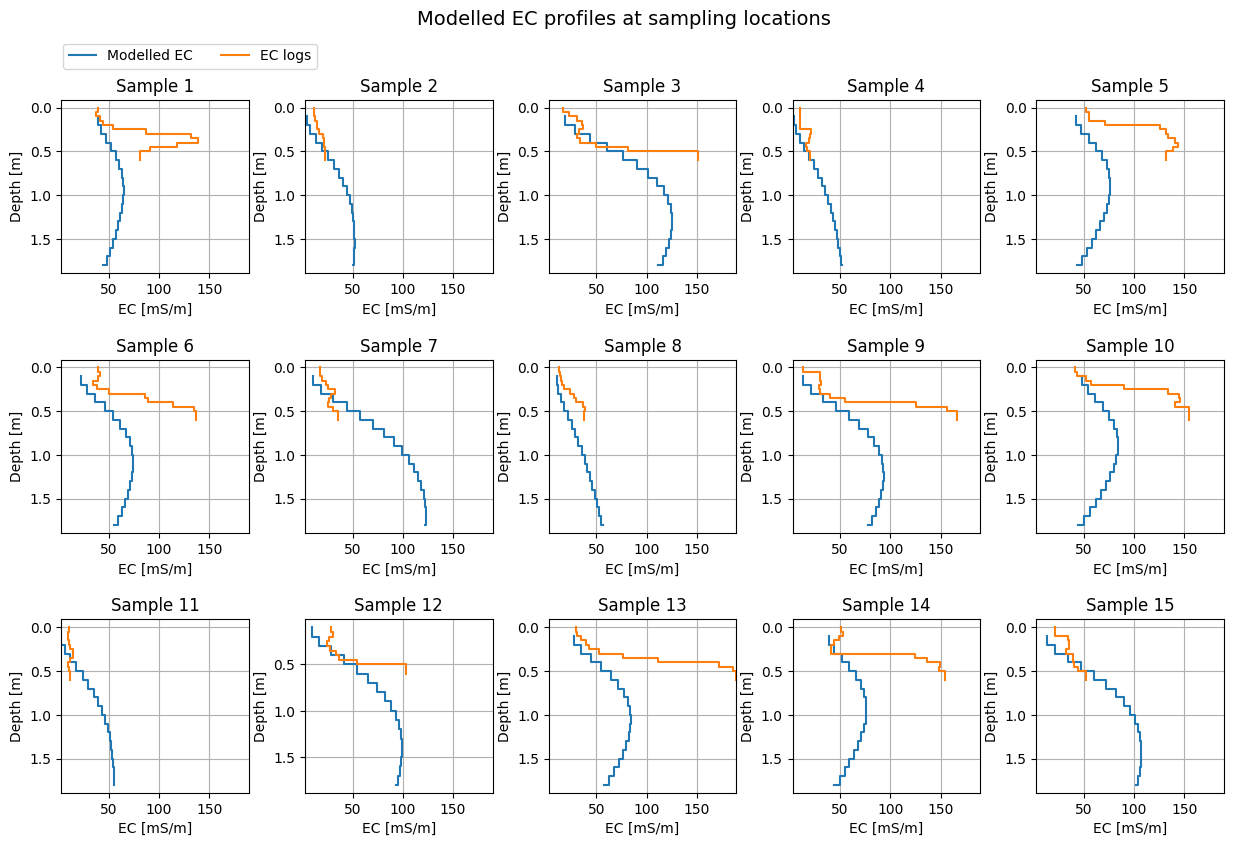

In [14]:
# 1.1: Comparing inverted EC logs with downhole EC data
# ------------------------------------------------------

save_to_file = False # set to True if you want to save the plots to a PDF

# ******************************************************************** #

# get inverted EC data columns from 02_ESS-... .ipynb export file
EC_cols = [col for col in d_inv_samps.columns if 'EC' in col[:2] 
           and len(col) < 8 and 'hydra' not in col]

# get interface depths
for i, col in enumerate(EC_cols):
    if i == 0 and col != 'EC_end':
        depth_values = [float(col[3:])]
    elif col != 'EC_end':
        depth_values.append(float(col[3:]))

# Add the last depth value
depth_values.append(depth_values[-1] + (depth_values[-1] - depth_values[-2]))

unique_sample_ids = d_inv_samps['ID'].unique()

# number of subplot rows and columns
subplot_rows = 3
subplot_cols = 5

# Get axis limits based on conductivity values in inverted and field datasets
global_x_min = min(d_inv_samps[EC_cols].min().min(), d_ec_logs['EC_msm'].min())
global_x_max = max(d_inv_samps[EC_cols].max().max(), d_ec_logs['EC_msm'].max())

# Create the subplots
fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 9))
fig.subplots_adjust(hspace=0.5, wspace=0.3)
# Loop through each sample ID and plot the EC values
for i, sample_id in enumerate(unique_sample_ids):
    # Get row index for the current sample ID
    row_index = d_inv_samps.loc[d_inv_samps['ID'] == sample_id].index[0]
    row_data = d_inv_samps.loc[row_index, EC_cols].values
    # Get the current subplot axis
    ax = axes[i // subplot_cols, i % subplot_cols]
    # Get the EC logs data for the current sample ID
    data = d_ec_logs[d_ec_logs['ID'] == sample_id]
    # append additional depth value that is 0.10 m deeper than last depth value
    new_row = pd.DataFrame([{'EC_msm': data['EC_msm'].iloc[-1], 
                             'depth_m': data['depth_m'].iloc[-1] + 0.10}])
    data = pd.concat([data, new_row], ignore_index=True)

    if sample_id == 1:
        ax.step(row_data, depth_values, label=f'Modelled EC')
        ax.step(data['EC_msm'], data['depth_m'], label=f'EC logs')
    else:
        ax.step(row_data, depth_values)
        ax.step(data['EC_msm'], data['depth_m'])

    ax.set_xlabel('EC [mS/m]')
    ax.set_ylabel('Depth [m]')
    ax.set_title(f'Sample {int(sample_id)}')
    ax.set_xlim(global_x_min, global_x_max)
    ax.invert_yaxis()
    ax.grid(True)
fig.legend(bbox_to_anchor=(0.3, 0.95), ncol=2)
fig.suptitle('Modelled EC profiles at sampling locations', fontsize=14)
plt.show()

# Export the plots as a PDF
if save_to_file==True:
    with PdfPages(export_path + '/modECprofiles_sampleloc.pdf') as pdf:
        pdf.savefig(fig)

# 2 - Pedophysical modelling - predicting bulk EC

Pedophysical models are models that aim to describe the relationship between the observed geophysical properties, and the soil properties and states of interest. Generally, a geophysical property of a soil (i.e., a soil being a medium that integrates multiple phases) is influenced by the soil constituents (i.e., the relative volumetric proportion of the soil components and their physical properties), and the soil structure (i.e., the spatial distribution of the soil constituents and their interconnection). 

### Archie's Law
In class, we have briefly discussed Archie's law, which, when modified for soils, primarily accounts for the conductivity of the pore fluid ($\sigma_{wat}$), and considers the degree of saturation $S_{wat}$ alongside a saturation exponent $n$, which relates to the pore structure of the medium. The degree of saturation equals the ratio of the volumetric water content ($\theta$) to the porosity ($\phi$) of the medium:

$$
S_{wat} = \frac{\theta}{\phi}
$$


The combined Archie’s law is:

$$
\sigma = \phi^{m} \times S_{wat}^{n} \times \sigma_{wat}.
$$

This allows estimating the conductivity $\sigma$ for partially saturated media whereby $m$ (fixed at 1.5) and $n$ (fixed at 2) allow including the influence of the medium’s structure.
____
<br>

### Waxman and Smits equation 
One major shortcoming of Archie’s law was originally developed for sandy rocks, which presents significant shortcomings when applied to other media such as soils. Most importantly, surface conduction (i.e., the conduction along the surface of dry particles) is not taken into account. In all soils, the influence of surface conductance is non-negligible, and increases with clay content. Other models account for this, such as the adjustment proposed by [Waxman & Smits (1968)](https://users.ugent.be/~pjdsmedt/ESS2023/WS_1986.pdf), who quantify the surface conductivity ($\sigma_{surface}$) by defining a parameter $Q_V$ based on the cation exchange capacity ($CEC$):


$$
Q_v = pd \frac{1-\phi}{\phi} \times CEC ,
$$

with $pd$ the particle density. This results in the following relationship with bulk electrical conductivity:

$$
\sigma = \frac{1}{\phi^{-2}} \times (\sigma_{water} + B \times Q_v),
$$

resulting in the surface conductivity:

$$
\sigma_{surface} = (B \times Q_v \times S_{wat} \times \phi^{m}).
$$

Hereby, $B$ represents an equivalent counterion (sodium clay-exchange cations) conductivity that is determined empirically ([Revil et al. 1998](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/98JB02125)).
___
<br>

### Linde et al. 2006
More recently, a push towards more practical integrations of the surface conductivity
The equation from [Linde et al. 2006](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006WR005131) mentioned in [Romero-Ruiz et al. 2018](http://doi.wiley.com/10.1029/2018RG000611), integrates the surface conductivity as follows:

$$
\sigma = \phi^{m} \times S_{wat}^{n} \times \sigma_{water} + (1 - \phi^{m}) \times \sigma_{surface} .
$$

Hereby, the surface conductivity is derived from soil texture, through empirical observations, by attributing more weight to a set conductivity of solid particles as the particle size decreases.

### Fu et al. 2021
An alternative formulation of this approach was presented by [Fu et al., 2021](https://www.sciencedirect.com/science/article/pii/S0022169421002079):

$$
\sigma = \sigma_{water} \times \theta^{w} + \theta \times \phi \times \sigma_{surface} + (1-\phi) \times \sigma_{solid},
$$

with a constant $w$ that has an average values of 2, respectively. The conductivity of the solid phase, which is negligible, is included as $\sigma_{solid}$. 
Based on empirical data, the surface conductivity $\sigma_{surface}$ is then simplified as:

$$
\sigma_{surface} = 0.654\frac{clay}{sand + silt} + 0.0183 ,
$$

following [Doussan & Ruy (2009)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2008WR007309). For the function presented by [Fu et al. 2021](https://www.sciencedirect.com/science/article/pii/S0022169421002079), extensive calibration was performed based on soil samples with clay content ranging from 0 to 33%.

An overview of these and other pedophysical models can be found in [Mendoza et al. (2024)](https://arxiv.org/pdf/2403.07473.pdf).

The equations incorporating surface conductivity are provided in **_code cell 2.0_** as `waxsmith`, `linde`, and `fu`, respectively. 
You can test these for a range of varying soil properties in **_code cell 2.1_**. 

In [15]:
# 2.0: Pedophysical modelling - Linde et al. 2006
# -----------------------------------------------
help(waxsmits)
help(linde)
help(fu)

Help on function waxsmits in module Utils.func:

waxsmits(vwc, bd, water_ec, CEC, pdn=2.65, m=1.5, n=2, a=0.4)
    Pedophysical modelling following the revised Waxman-Smits model
    as proposed by Revil et al. 2013.
    
    Parameters
    ----------
    vwc: float
        volumetric water content [%]
    
    bd: float
        bulk density [g/cm3]
    
    CEC: float
        cation exchange capacity [meq/100g]
    
    water_ec: float
        Soil water real electrical conductivity [mS/m]
    
    pdn: float
        particle density [g/cm3]
    
    m: float
        cementation exponent [-]
    
    n: float
        saturation exponent [-]
    
    a: float
        fitting parameter [-] (see Wunderlich et al. 2013)
    
    Returns
    -------
    bulk_ec: float
        Soil bulk real electrical conductivity [mS/m]

Help on function linde in module Utils.func:

linde(vwc, bd, water_ec, clay, sand, pdn=2.65, m=1.5, n=2)
    Pedophysical modelling following the Linde et al. 2006 model.

### Dynamic evaluation of pedophysical models

In the following two code cells you can evaluate the pedophysical models presented above dynamically, by modifying input parameter values with sliders. If needed, you can adjust the starting values and ranges for the sliders. Keep in mind that setting all slides to a maximum value can lead to unrealistic scenarios (e.g., unrealistically high bulk densities for clayey soils).

In [ ]:
# 2.1: Evaluate the Waxman-Smits model with Revil et al. 1998 modification
# -------------------------------------------------------------------------

"""
In this cell, code is provided to evaluate the Wasmits model with the 
Revil et al. 1998 modification. You can modify the starting values and ranges
for the relevant parameters (CEC, VWC, BD, ECW) to evaluate the model's outcome
in different scenarios.
"""

# Set starting values and ranges for sliders
min_CEC = 1; max_CEC = 50
min_bd = 1.0; max_bd = 2.1
min_vwc = 10; max_vwc = 50
min_ecw = 10; max_ecw = 100   

# ******************************************************************** #
# Create empty arrays to populate with values
iterations = 100
CEC_i = np.linspace(min_CEC, max_CEC, iterations)
vwc_i = np.linspace(min_vwc, max_vwc, iterations)
b_dens_i = np.linspace(min_bd, max_bd, iterations)

# Update plot function
# we used updated plot function 

# Define sliders
CEC_slider = FloatSlider(value=min_CEC, min=min_CEC, max=max_CEC, 
                         step=0.1, description='CEC [mmol/g]')
VWC_slider = FloatSlider(value=min_vwc, min=min_vwc, max=max_vwc, 
                         step=0.1, description='VWC [%]')
BD_slider = FloatSlider(value=min_bd, min=min_bd, max=max_bd, 
                        step=0.01, description='BD [g/cm^3]')
ECW_slider = FloatSlider(value=min_ecw, min=min_ecw, max=max_ecw, 
                         step=0.1, description='EC_w [mS/m]')

# Use interact to create interactive widgets
interact(
    lambda CEC, VWC, ECW, BD: update_plot2(CLAY, VWC, ECW, BD, vwc_i, CEC_i, b_dens_i),
    CLAY=CEC_slider,
    VWC=FloatSlider(min=0, max=50, step=1, value=25, description='VWC'),
    ECW=FloatSlider(min=0, max=100, step=1, value=10, description='ECW'),
    BD=FloatSlider(min=0, max=2, step=0.1, value=1.3, description='BD')
)

interactive(children=(FloatSlider(value=20.0, description='CLAY', step=1.0), FloatSlider(value=25.0, descripti…

<function __main__.<lambda>(CLAY, VWC, ECW, BD)>

In [ ]:
# 2.1: Evaluate the Linde et al 2016 and Fu et al. 2021 models
# ----------------------------------------------------------------------

""" 
In this cell, code is provided to evaluate the Linde et al. 2006 and Fu et al.
2021 models. You can modify the starting values and ranges for the relevant
parameters (clay, VWC, ECW, BD) to evaluate the model's outcome in different
scenarios.
"""

# Set starting values and ranges for sliders
min_clay = 5; max_clay = 40
min_vwc = 10; max_vwc = 50
min_ecw = 10; max_ecw = 100
min_bd = 1.0; max_bd = 2.1

# getting clay and bd range n iterations
iterations = 100
clay_i = np.linspace(min_clay, max_clay, iterations)
b_dens_i = np.linspace(min_bd, max_bd, iterations)
vwc_i = np.linspace(min_vwc, max_vwc, iterations)

# Define sliders for each parameter and assure that sliders are positioned below the plots
clay_slider = FloatSlider(value=min_clay, min=min_clay, max=max_clay, step=0.1, description='Clay content [%]', style={'description_width': 'initial'}) 
vwc_slider = FloatSlider(value=min_vwc, min=min_vwc, max=max_vwc, step=0.1, description='VWC [%]', style={'description_width': 'initial'}) 
ecw_slider = FloatSlider(value=min_ecw, min=min_ecw, max=max_ecw, step=0.1, description='EC_w [mS/m]', style={'description_width': 'initial'}) 
bd_slider = FloatSlider(value=min_bd, min=min_bd, max=max_bd, step=0.01, description='BD [g/cm^3]', style={'description_width': 'initial'}) 

# Interactive widget
interact(update_plot, CLAY=clay_slider, VWC=vwc_slider, ECW=ecw_slider, BD=bd_slider)


interactive(children=(FloatSlider(value=5.0, description='Clay content [%]', max=40.0, min=5.0, style=SliderSt…

<function __main__.update_plot(CLAY, VWC, ECW, BD)>

### Evaluating sampling data

In **_code cell 2.2_** you can evaluate the performance of these models by comparing the modelled soil EC values based on the analytical data, and comparing these to point EC data collected with the HydraProbe during fieldwork, and any of the FDEM datasets. Just specify the FDEM dataset to evaluate. You can choose the fix the conductivity on the pore solution, to evaluate what impact this has on the prediction, by setting the `fix_ec_water` variable to `True`. This will use the average value of the pore solution conductivity as measured with the HydraProbe during fieldwork.  

By running **_code_cell 2.3_** you can add the EC values modelled through the Linde et al. (2006) equation to the samples dataframe (dataframe `ds`), and exporting it as a csv file to your Google drive.

_**REMINDER** to check the column names for a specific pandas dataframe, just visualise the '.columns' attribute, for instance as `ds.columns` for the `ds` dataframe that holds the sample data._

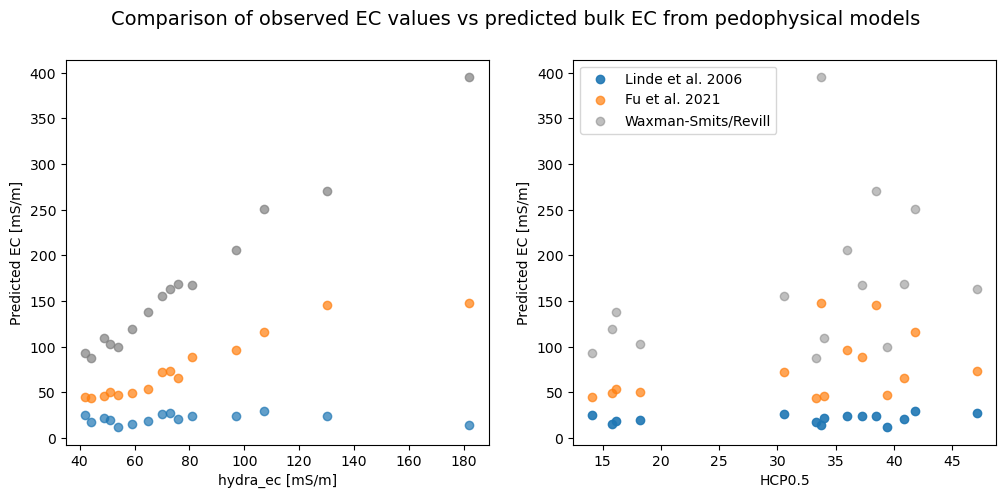

In [ ]:
# 2.2: Evaluating pedophysical relationships at sampling locations
# ----------------------------------------------------------------

save_to_file = False # set to True if you want to save the plots to a PDF

# Set the column names for EC datasets (plotted on x-axes) you want to compare 
# with the EC values predicted by the pedophysical models (plotted on y-axes)

EC_col = 'EC_bulk_hydra' # Default = hydraprobe bulk EC values 
fdem_col = 'HCP0.5' # Default = 0.5 m HCP FDEM dataset. You can change this to columns of the inverted FDEM data at sampling locations

# Set conductivity of the pore solution as fixed (ec_water_avg variable)'

fix_ec_water = False # if False, for each sample location the EC_water value 
                     # measured by the HydraProbe is used
ec_water_avg = d_inv_samps['EC_water_hydra'].median() # fixed EC_water [mS/m]

# ******************************************************************** #

# Initialize empty lists to store the predicted bulk_ec values
predicted_bulk_ec_linde = []
predicted_bulk_ec_fu = []
predicted_bulk_ec_ws = []

# Loop through the rows of the DataFrame
for index, row in d_inv_samps.iterrows():
    # Get the input values from the DataFrame
    vmc = row['vmc_hydra']
    bd = row['bd_10cm']
    sand = row['sand_10cm']
    CEC = row['CEC_10cm']
    silt = row['silt_10cm']
    clay = row['clay_10cm']
    if fix_ec_water:
        water_ec = ec_water_avg
    else:
        water_ec = row['EC_water_hydra']
    
    # Calculate the bulk electrical conductivity based on linde and fu models
    bulk_ec_linde = linde(vmc, bd, sand, clay, water_ec)
    bulk_ec_fu = fu(vmc, bd, water_ec, clay)
    # waxsmits(vwc, bd, water_ec, CEC, pdn=2.65, m=1.5, n=2, a = 0.4):
    bulk_ec_ws = waxsmits(vmc, bd, water_ec, CEC)

    # Store the predicted bulk_ec values
    predicted_bulk_ec_linde.append(bulk_ec_linde)
    predicted_bulk_ec_fu.append(bulk_ec_fu)
    predicted_bulk_ec_ws.append(bulk_ec_ws)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 5])

# Plot bulk_ec versus hydra_ec [mS/m]
axes[0].scatter(d_inv_samps[EC_col], predicted_bulk_ec_linde, alpha=0.7)
axes[0].scatter(d_inv_samps[EC_col], predicted_bulk_ec_fu, alpha=0.7)
axes[0].scatter(d_inv_samps[EC_col], predicted_bulk_ec_ws, alpha=0.7, color='gray')

# # UNCOMMENT TO ADD A TRENDLINE TO EACH PLOT
# # add trendline to each plot
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ds['hydra_ec [mS/m]'], predicted_bulk_ec_linde)
# line = slope * ds['hydra_ec [mS/m]'] + intercept
# axes[0].plot(ds['hydra_ec [mS/m]'], line, label='Linde et al. 2006')
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ds['hydra_ec [mS/m]'], predicted_bulk_ec_fu)
# line = slope * ds['hydra_ec [mS/m]'] + intercept
# axes[0].plot(ds['hydra_ec [mS/m]'], line, label='Fu et al. 2021')
# slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ds['hydra_ec [mS/m]'], predicted_bulk_ec_ws)
# line = slope * ds['hydra_ec [mS/m]'] + intercept
# axes[0].plot(ds['hydra_ec [mS/m]'], line, label='Waxman-Smits/Revill')
# axes[0].legend()

axes[0].set_xlabel("hydra_ec [mS/m]")
axes[0].set_ylabel("Predicted EC [mS/m]")
#axes[0].set_title("Predicted EC vs hydra_ec")

# Plot bulk_ec versus selected FDEM column LIN ECa [mS/m]
axes[1].scatter(ds[fdem_col], predicted_bulk_ec_linde, alpha=0.9, 
                label = "Linde et al. 2006")
axes[1].scatter(ds[fdem_col], predicted_bulk_ec_fu, alpha=0.7, 
                label = "Fu et al. 2021")
axes[1].scatter(ds[fdem_col], predicted_bulk_ec_ws, alpha=0.5, color='gray', 
                label = "Waxman-Smits/Revill")
axes[1].legend()
axes[1].set_xlabel(fdem_col)
axes[1].set_ylabel("Predicted EC [mS/m]")
#axes[1].set_title(f"Predicted EC vs {fdem_col}")

fig.suptitle('Comparison of observed EC values vs predicted bulk EC'
              ' from pedophysical models', fontsize=14)

plt.show()

if save_to_file==True:
    with PdfPages(export_path + '/obsECvspredEC.pdf') as pdf:
        pdf.savefig(fig)

In [ ]:
# 2.3: Store predicted EC values in the `d_inv_samps` dataframe and save .csv
# ---------------------------------------------------------------------------

"""
Here you can export the predicted bulk EC values from the pedophysical models
to a .csv file. Per default, this will be a file that combines your inversion
results at the sampling locations, the FDEM ECa data, the sample information,
and the predicted bulk EC values from the Linde, Fu and Waxman-Smits models.
"""

# Define a filename for exporting
filename = 'samples_and_predictions.csv'

# ******************************************************************** #
# Create column for predicted EC values (in mS/m) in the d_inv_samps dataframe and export as csv
d_inv_samps['Linde EC_predict [mS/m]'] = predicted_bulk_ec_linde
d_inv_samps['Fu EC_predict [mS/m]'] = predicted_bulk_ec_fu
d_inv_samps['Waxman-Smits EC_predict [mS/m]'] = predicted_bulk_ec_ws
d_inv_samps.to_csv(export_path + '/' + filename, index=False)  

# 3. Exploring relationships between target properties and observed geophysical variations.

To evaluate to which extent the collected FDEM data can help predict the spatial variability of your group's target property, it is important to understand the relationship between the sensor output, and the targeted properties. This can be done at the sampling locations by further exploring the `d_inv_samps` dataframe that contains the FDEM data and analytical data at these locations, as well as your inversion results ath these locations. For instance, you can compare the FDEM ECa data to a given property at a given depth, and make the same comparision with the Hydraprobe EC data.

## Stochastic modelling
A stochastic empirical approach can be used as a basis for predictions. As an example, a regression analysis is included in **_code cell 3.1_**. 
The obtained linear function is incorporated in the 'lin_fit' object. You can obtain the function by simply printing the objects as: `print(lin_fit)`, as is done in **_code cell 3.1_**. 

To extract the slope and intercept from the linear model, you can directly access these as:

`slope = lin_fit[1]` <br />
`intercept = lin_fit[0]`,

Suited models, that avoid overfitting and provide satisfactory prediction errors, can then be used to predict the target variable based on the obtained model. 
Alongside the regression analysis, a cross-validation is performed using the 'leave-one-out' method.

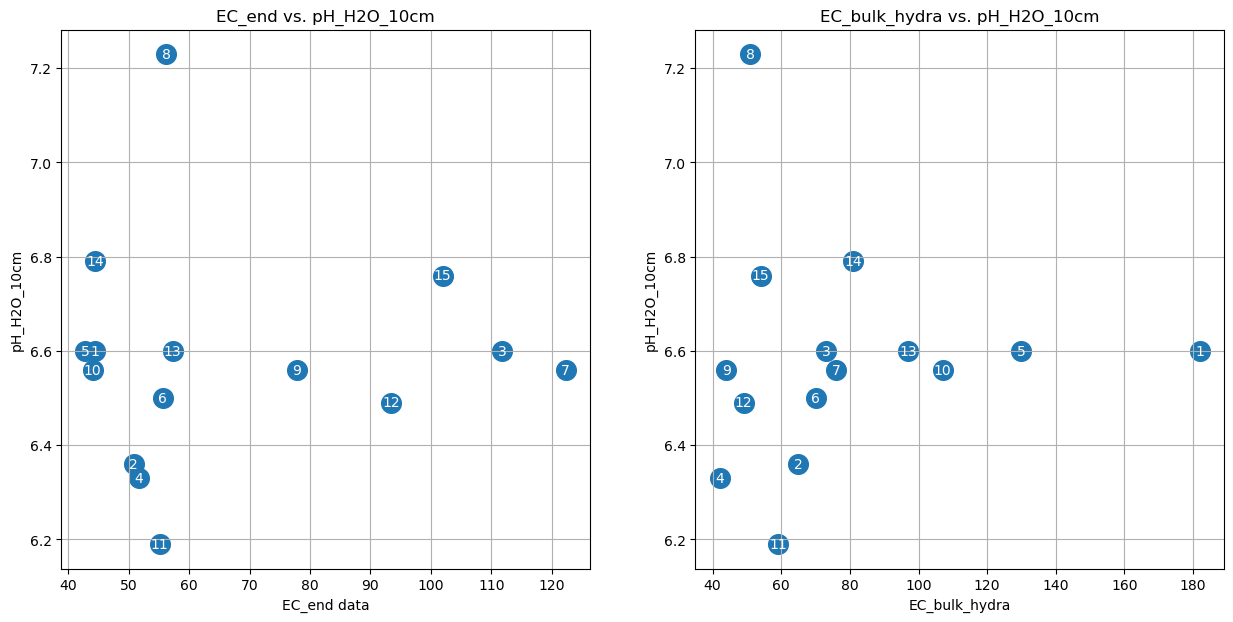

In [ ]:
# 3.0: evaluating relationships between target properties and conductivity data
# -----------------------------------------------------------------------------

save_to_file=False # set to True if you want to save the plots to a PDF 

target = 'pH_H2O_10cm' # ds columnname for column with target property 
fdem_col = 'EC_end' # ds columnname for column with FDEM dataset (inverted or non-inverted)
hydra_col = 'EC_bulk_hydra' # ds columnname for hydraprobe data column

# create a copy of the sample dataset to plot and, if needed, filter out
# specific points (outliers/validation data/...)
ds_in = d_inv_samps.copy()

# # uncomment these lines to remove the validation or other points 
# exclude_points = [11, 12, 13, 14, 15] # replace with point ID's you want to remove
# ds_in = ds_in[~ds_in['ID'].isin(exclude_points)]

# ******************************************************************** #

# -----------------------------------------------------------
# Plotting
# -----------------------------------------------------------

fig, ax = plt.subplots(1,2, figsize=(15,7))
# Define different axes for plotting

# FDEM compare plot
ax[0].scatter(ds_in[fdem_col],ds_in[target], s=200)
ax[0].set_xlabel(f'{fdem_col} data')
ax[0].set_ylabel(f'{target}')
# add sample ID labels to the plot
for index, row in ds_in.iterrows():
    ax[0].text(row[fdem_col], row[target], str(int(row['ID'])), 
    fontsize=10, ha='center', va='center', color='white')
ax[0].grid()
ax[0].set_title(f'{fdem_col} vs. {target}')

# HyrdaGo compare plot
ax[1].scatter(ds_in[hydra_col],ds_in[target], s=200)
ax[1].set_xlabel(hydra_col)
ax[1].set_ylabel(f'{target}')

#   add sample ID labels to the plot
for index, row in ds_in.iterrows():
    ax[1].text(row[hydra_col], row[target], str(int(row['ID'])), 
    fontsize=10, ha='center', va='center', color='white')
ax[1].grid()
ax[1].set_title(f'{hydra_col} vs. {target}')

plt.show()

if save_to_file==True:
    with PdfPages(export_path + '/target_vs_EC.pdf') as pdf:
        pdf.savefig(fig)

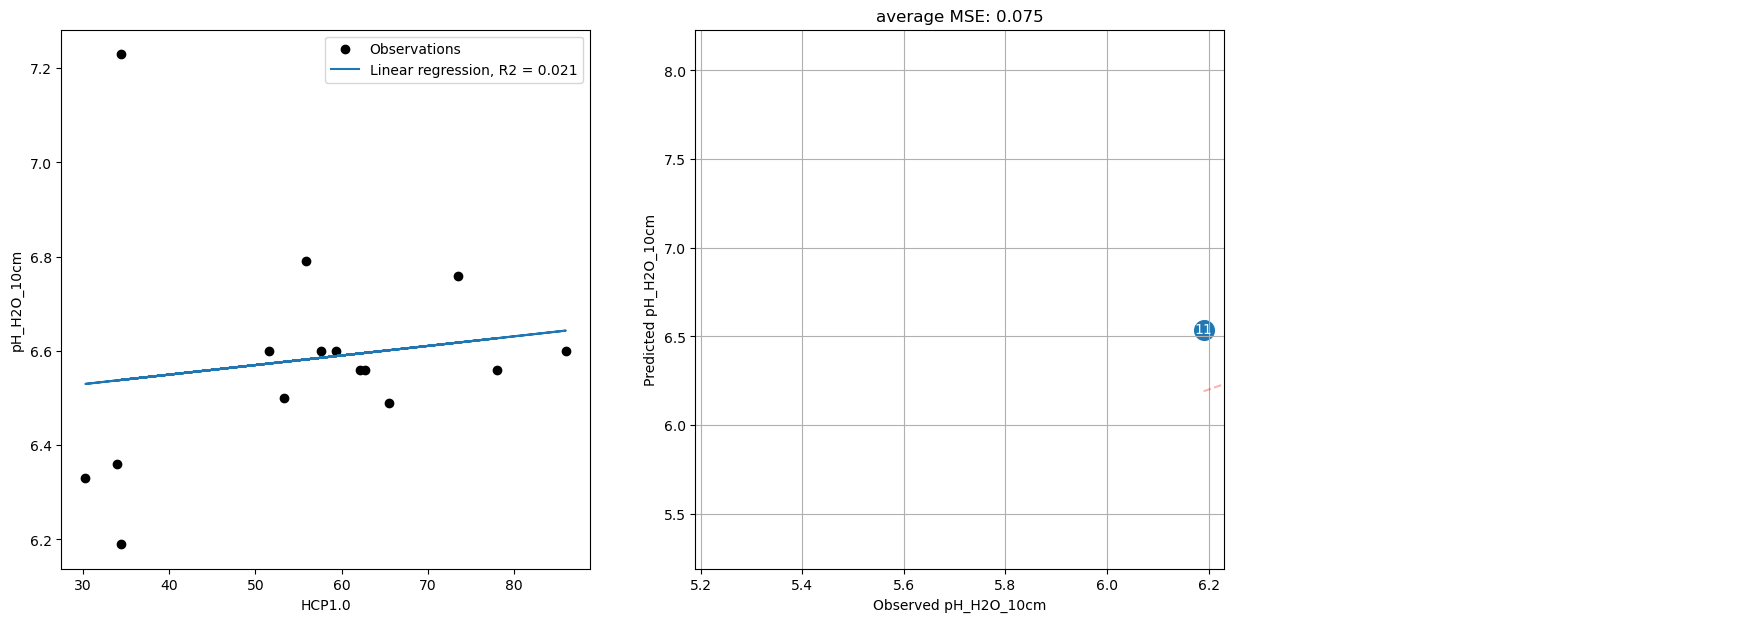

In [ ]:
# 3.1: Perform a linear regression with numpy and evaluate the model
# --------------------------------------------------------------------

save_to_file=False # set to True if you want to save the plots to a PDF

target = 'pH_H2O_10cm' # d_inv_samps column name for target property
fdem_col = 'HCP1.0' # d_inv_samps column name for FDEM dataset (inverted or ECa)

# ******************************************************************** #

# create columnname with name based on target variable
col_name = f'predicted_{target}'

# Ensure the dataset is clean and well-prepared
ds_in.dropna(inplace=True)
ds_in[fdem_col] = pd.to_numeric(ds_in[fdem_col], errors='coerce')
ds_in[hydra_col] = pd.to_numeric(ds_in[hydra_col], errors='coerce')
ds_in[target] = pd.to_numeric(ds_in[target], errors='coerce')

# Extract features and target variables
X = ds_in[fdem_col].values.reshape(-1, 1)
y = ds_in[target].values

# Sort the dataset based on the feature variable
X_sorted = np.sort(X, axis=0)

# numpy
lin_fit = np.poly1d(np.polyfit(ds_in[fdem_col].values, 
                               ds_in[target].values, 1))
ds_in[col_name] = lin_fit(ds_in[fdem_col].values)

# Calculate R-squared for model using 'leave-one-out' cross-validation
# implemented via scikit-learn (sklearn)

# Calculate R-squared for linear model
r2_linear_numpy = r2_score(y, lin_fit(X))

# Cross-validation (leave-one-out)
# --------------------------------
# iterate over the dataset and calculate the MSE for each iteration using
# the leave-one-out via Scikit-learn
loo = LeaveOneOut()
mse_scores_numpy = []
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lin_fit = np.poly1d(np.polyfit(X_train[:,0], y_train, 1))
    y_pred_numpy_eval = lin_fit(X_test[:, 0])

    # calculate the mean squared error for each iteration
    mse_scores_numpy.append(mean_squared_error(y_test, y_pred_numpy_eval))

# calculate the average mean squared error
average_mse_numpy = np.mean(mse_scores_numpy)

# Plotting
fig, ax = plt.subplots(1,2, figsize=(15,7))

# plot the linear regression model against input vs target data
ax[0].scatter(ds_in[fdem_col], ds_in[target], 
              color='black', label='Observations')
ax[0].plot(ds_in[fdem_col], ds_in[col_name], 
           label=f'Linear regression, R2 = {r2_linear_numpy:.3f}')
ax[0].set_xlabel(fdem_col)
ax[0].set_ylabel(target)
ax[0].legend()

# plot comparison of observed and predicted target property
# add 1:1 line
ax[1].plot([ds_in[target].min(), ds_in[target].max()], 
            [ds_in[target].min(), ds_in[target].max()], 
            color='red', alpha=0.3, linestyle='--')
ax[1].scatter(ds_in[target], ds_in[col_name], s=200)
# add sample ID labels
for index, row in ds_in.iterrows():
    ax[1].text(row[target], row[col_name], str(int(row['ID'])), 
            fontsize=10, ha='center', va='center', color='white')

ax[1].set_xlabel(f'Observed {target}')
ax[1].set_ylabel(f'Predicted {target}')
ax[1].set_title('average MSE: {:.3f}'.format(average_mse_numpy))
# Set ax[1] limits
combined_min = min(ds_in[target].min(), ds_in[col_name].min())
combined_max = max(ds_in[target].max(), ds_in[col_name].max())
ax[1].set_xlim([combined_min-1, combined_max-1])
ax[1].set_ylim([combined_min-1, combined_max+1])
ax[1].grid()

plt.show()

if save_to_file==True:
    with PdfPages(export_path + '/linear_regression.pdf') as pdf:
        pdf.savefig(fig)

## Perform prediction for entire survey area

In **_code cell 3.2_** you can apply a suited model to the entire FDEM dataset. You can specify the target and the data feature (FDEM dataset or inverted EC layer) to preform the prediction with. Make sure that you use the suited model (i.e., use the same input data as you trained your model on). 
In the cell, you can interpolate and export the predicted property map to a georeferenced raster, as well as to a .csv file.

You can then import these data into your GIS and compare it to available information on your target property. 

_Sidenote: to change the plot colormaps, you find reference info on the [Matplotlib documentation site](https://matplotlib.org/stable/users/explain/colors/colormaps.html)_

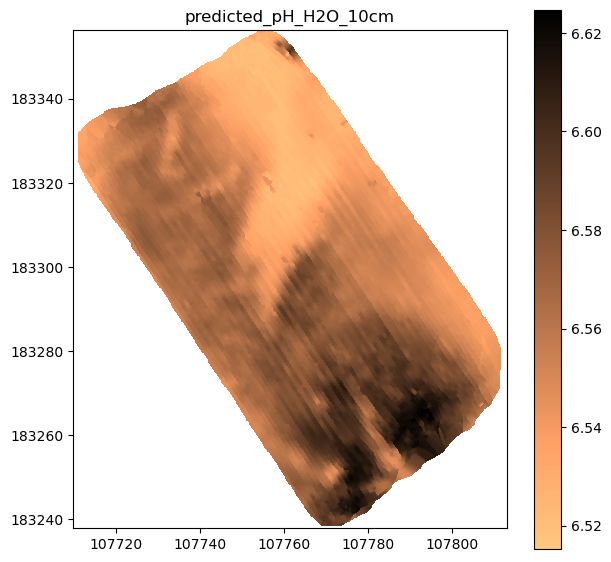

In [ ]:
# 3.2: Predict a target property based on the regression model from code cell 3.1
# --------------------------------------------------------------------------

# If needed, you can replace d_inv with another dataframe 
# The d_inv dataframe contains the full inverted (see code cell 0.1)
dpred_in = d_inv.copy() 

# Set the dataframe column name that holds the EC values.For the inverted
# EC values, the column names depend on the boundaries you have set.
fdem_col = 'EC_0.60'

# column name for the EC values you want to use for the prediction
# SAME AS SPECIFIED FOR THE MODEL YOU CREATED IN 3.1
target = target 
col_name = f'predicted_{target}' # column name for the predicted target property

# Interpolate the predicted target property values to a grid and export
cell_size = 0.25
export_raster = True # if true the interpolated data will be exported as a geoTIFF
export_csv = True # if true the interpolated data will be exported as a CSV

# ******************************************************************** #
# Run prediction based on the linear model from cell 3.1
dpred_in[col_name] = lin_fit(dpred_in[fdem_col].values)

# Interpolate results and plot the outcome
cell_size = 0.25

prediction_grid = interpolate(dpred_in['x'], dpred_in['y'], dpred_in[col_name], cell_size=cell_size)
grid_name = f'{col_name}_grid'
# Specify the grid extent for plotting with correct x-y coordinates
extent = prediction_grid['extent']

# Plot
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(prediction_grid['grid'], 
                origin='lower', 
                extent=(extent['x_min'],
                        extent['x_max'],
                        extent['y_min'],
                        extent['y_max']),
                cmap = 'copper_r'
                )
# Set limits to the plotting range based on data percentiles by 
# uncommenting the 4 lines below: 

# pmin = 2  # lower percentile
# pmax = 98  # upper percentile 
# im.set_clim(np.percentile(data_grid['grid'].flatten()[~np.isnan(data_grid['grid'].flatten())], pmin),
#         np.percentile(data_grid['grid'].flatten()[~np.isnan(data_grid['grid'].flatten())], pmax))

ax.set_title(f"{col_name}")
plt.colorbar(im, ax=ax)

if export_raster:
    # Export the interpolated data as a GeoTIFF
    export_grid(prediction_grid, filename=grid_name, export_path=export_path)

if export_csv:
   # generate dataframe with only predicted values (col_name) and columns 'x', 'y', and the fdem_col
    dpred_out = dpred_in[['x', 'y', fdem_col, col_name]]
    dpred_out.to_csv(export_path + f'/{col_name}_grid.csv', index=False) 